In [87]:
import numpy as np 
from functions import *
import structures as st
from sklearn.datasets import make_spd_matrix

import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle

from sklearn.datasets import fetch_olivetti_faces
import logging 
from numpy.random import RandomState
rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = faces - faces.mean()

J = 1 
from noise_functions import add_spnoise, add_noise
dataset = []
noise_level = np.sqrt(0.005)
prob = 0.3
noisies = []
for img in faces_centered[0:300]:
    noisy = add_spnoise(img.reshape(64,64).copy(), noise_level, prob).reshape(64,64)
    noisy = (noisy - noisy.min())/(noisy.max() - noisy.min())
    im = img.reshape(64,64)
    im = (im - im.min())/(im.max() - im.min())
    dataset.append([img.reshape(64,64), noisy])
    noisies.append(noisy)

dataset_test = []
noisies_test = []
for img in faces_centered[J:]:
    noisy = add_spnoise(img.reshape(64,64).copy(), noise_level, prob).reshape(64,64)
    noisy = (noisy - noisy.min())/(noisy.max() - noisy.min())
    im = img.reshape(64,64)
    im = (im - im.min())/(im.max() - im.min())
    dataset_test.append([img.reshape(64,64), noisy])
    noisies_test.append(noisy)
    
def proj_pos(A):

    d, O = np.linalg.eigh(A)

    return O@np.diag(np.maximum(d, 0))@O.T

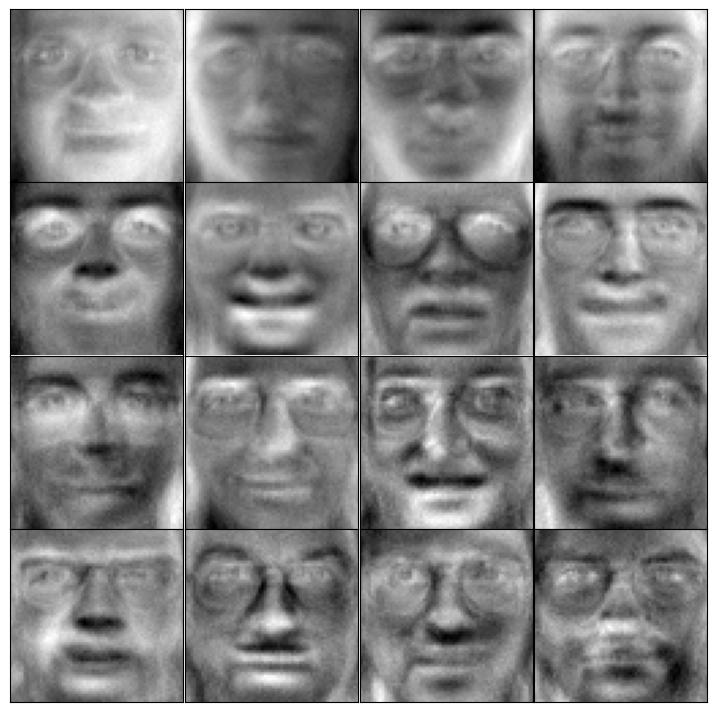

In [88]:
from sklearn.decomposition import PCA
n = 4
faces = PCA(n_components=n**2)
faces.fit([noisy.reshape(64*64) for noisy in noisies])
fig, axes = plt.subplots(n,n,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.0, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(faces.components_[i].reshape(64,64),cmap='gray')

In [89]:
transformed = faces.transform([test.reshape(64*64) for test in noisies])

In [90]:
def denoise_unsupervised(noisy, verbose):
    initial_Phi = [make_spd_matrix(n**2)/(100 * n ** 2) for _ in range(n**2)]
    TV_Ls = [TV(faces.components_[i].reshape(64,64)) for i in range(n ** 2)]
    kappa = 50
    L = 10 * n**2
    v0 = im_dual(noisy)
    Sigma = [0 * phi for phi in initial_Phi]
    tilde_Phi = initial_Phi.copy()
    Lxi = faces.transform([noisy.reshape(64*64)])

    alpha = 0 
    for i, phi in enumerate(initial_Phi):
        val = (Lxi @ phi @ Lxi.T) * TV_Ls[i]
        alpha += val 
    alpha = alpha[0][0]
    #print(f'Initial Alpha: {alpha}')
    v = v0
    Phi = initial_Phi.copy()

    k = 0 
    max_its = 500
    tv = TV(noisy)#TV(dataset[s][0])
    for k in range(max_its):
        for i, phi in enumerate(Phi):
            sigma = phi - 1/kappa * (tv * TV_Ls[i] - TV(div(im_dual(v) + noisy)))
            tilde_Phi[i] = proj_pos(sigma)
            tilde_v = v 
            
        alpha = 0 
        for i, phi in enumerate(Phi):
            val = (Lxi @ phi @ Lxi.T) * TV_Ls[i]
            alpha += val 
        alpha = alpha[0][0]
        for s in range(64):
            for t in range(64):
                val = np.array([tilde_v[0, s,t], tilde_v[1, s,t]])
                if val[0] !=0:
                    tilde_v[0,s,t] = (val[0]/np.linalg.norm(val)) * alpha
                elif val[1] !=0:
                    tilde_v[1,s,t] = (val[1]/np.linalg.norm(val)) * alpha

        dual = im_dual(div(v) + dataset[s][0])
        Nk = -np.trace(dual[0].T @ (v[0] - tilde_v[0])) -np.trace(dual[1].T @ (v[1] - tilde_v[1]))
        for i, phi in enumerate(Phi):
            Nk += TV_Ls[i] * np.trace(phi.T @ (phi - tilde_Phi[i]))

        Bk = 0
        for i, phi in enumerate(Phi):
            Bk += L * kappa * np.linalg.norm(phi - tilde_Phi[i]) ** 2
        theta_k = min(1, Nk/Bk)

        v = v + theta_k * (tilde_v - v) 
        for i, phi in enumerate(Phi):
            Phi[i] = phi + theta_k * (tilde_Phi[i] - phi)
        
        k += 1
        if verbose:
            if k % int(max_its//10) == 0:
                print(f'{int(10 * k/(int(max_its//10)))}%, Alpha: {alpha}')
    
    denoised_img = denoise_tv_chambolle(noisy, 1/alpha)
    return denoised_img

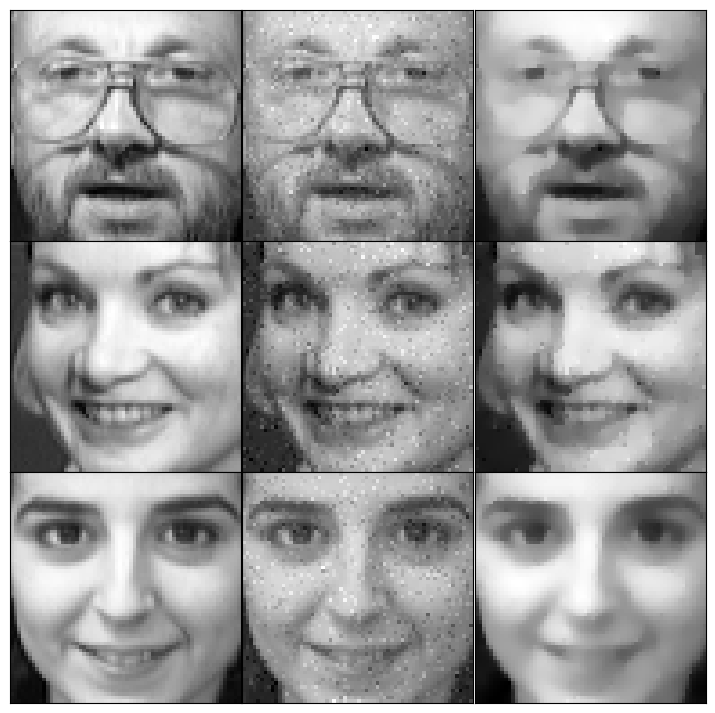

In [91]:
x = 10
y = 12
z = 35

fig, axes = plt.subplots(nrows = 3, ncols = 3,figsize=(18,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0, wspace=-0.75))
axes[0,0].imshow(dataset_test[x][0], cmap = 'grey')
axes[1,0].imshow(dataset_test[y][0], cmap = 'grey')
axes[2,0].imshow(dataset_test[z][0], cmap = 'grey')

axes[0,1].imshow(dataset_test[x][1], cmap = 'grey')
axes[1,1].imshow(dataset_test[y][1], cmap = 'grey')
axes[2,1].imshow(dataset_test[z][1], cmap = 'grey')

axes[0,2].imshow(denoise_unsupervised(dataset_test[x][1], False), cmap = 'grey')
axes[1,2].imshow(denoise_unsupervised(dataset_test[y][1], False), cmap = 'grey')
axes[2,2].imshow(denoise_unsupervised(dataset_test[z][1], False), cmap = 'grey')